In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets, models
import torch.optim as optim
from torch.autograd import Variable
# import torchvision

import numpy as np
import matplotlib.pyplot as plt
import copy
import time

<h2> 1. Data loading </h2>

In [2]:
# Check GPU availability
use_gpu = torch.cuda.is_available()
if use_gpu:
    pinMem = True
else:
    pinMem = False

In [3]:
train_dir = r"C:\Users\smitr\Desktop\train_10class"
valid_dir = r"C:\Users\smitr\Desktop\test_10class"

apply_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()])

# Training dataloader
train_dataset = datasets.ImageFolder(train_dir, transform=apply_transforms)
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4, pin_memory=pinMem)

# Testing dataloader
test_dataset = datasets.ImageFolder(valid_dir, transform=apply_transforms)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=4, pin_memory=pinMem)

In [4]:
# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainLoader.dataset)))
print('No. of samples in test set: '+str(len(testLoader.dataset)))

No. of samples in train set: 54794
No. of samples in test set: 13850


<h2> Define network architecture </h2>

In [5]:
# Mobilenet may also be used.
#net = models.mobilenet_v2(pretrained=True)
#print(net)
## Modifying the last layer for 10 classes
#net.classifier[1] = nn.Linear(1280, 10)

net = models.resnet18(pretrained=True)
# Modifying the last layer for 10 classes
net.fc = nn.Linear(512,10)

In [6]:
# Count no.of trainable parameters
total_params = 0
for params in net.parameters():
    print(params.size())
    total_params += np.sum(np.prod(params.size()))
print("No.of parameters: ",total_params)

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
t

In [7]:
if use_gpu:
    print("GPU is available !!!")
    net = net.cuda()

GPU is available !!!


<h2> Define loss function & optimizer </h2>

In [8]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.fc.parameters(), lr=1e-4)   # Just train the last layer

In [9]:
iterations = 10

trainLoss = []
trainAcc = []
testLoss = []
testAcc = []

start = time.time()
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0.0   
    avgTotalLoss = 0.0
    running_correct = 0   
    
    net.train(True) # For training 
    batchNum = 1
    for data in trainLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)          
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
        
        running_correct += (predicted.cpu() == labels.cpu()).sum().item()
       
        # Initialize gradients to zero
        optimizer.zero_grad()             
        
        # Compute loss/error
        loss = criterion(F.log_softmax(outputs), labels)
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.data.item()   
        batchNum += 1

    avgTrainAcc = running_correct/float(len(trainLoader.dataset))
    avgTrainLoss = runningLoss/float(len(trainLoader.dataset))    
    trainAcc.append(avgTrainAcc)
    trainLoss.append(avgTrainLoss)  
    
    # Evaluating performance on test set for each epoch
    net.train(False) # For testing [Affects batch-norm and dropout layers (if any)]
    running_correct = 0 
    for data in testLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels= Variable(inputs.cuda()), Variable(labels.cuda())
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)  
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            # Model 1
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
                
        running_correct += (predicted.cpu() == labels.cpu()).sum().item()
        
        loss = criterion(F.log_softmax(outputs), labels)
        
        runningLoss += loss.data.item()  

    avgTestLoss = runningLoss/float(len(testLoader.dataset))
    avgTestAcc = running_correct/float(len(testLoader.dataset))
    testAcc.append(avgTestAcc)  
    testLoss.append(avgTestLoss)
    
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f};  Training Loss: {:.6f} ; Training Acc: {:.3f}'\
          .format(epoch + 1,iterations,avgTrainLoss,avgTrainAcc*100))
    print('Iteration: {:.0f} /{:.0f};  Testing Loss: {:.6f} ; Testing Acc: {:.3f}'\
          .format(epoch + 1,iterations,avgTestLoss,avgTestAcc*100))
   
    print('Time consumed: {:.0f}m {:.0f}s'.format(epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))


c:\users\smitr\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
c:\users\smitr\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 1 /10;  Training Loss: 0.059708 ; Training Acc: 87.285
Iteration: 1 /10;  Testing Loss: 0.273305 ; Testing Acc: 90.845
Time consumed: 10m 10s
Iteration: 2 /10;  Training Loss: 0.017876 ; Training Acc: 96.452
Iteration: 2 /10;  Testing Loss: 0.104814 ; Testing Acc: 89.141
Time consumed: 10m 51s
Iteration: 3 /10;  Training Loss: 0.011930 ; Training Acc: 97.460
Iteration: 3 /10;  Testing Loss: 0.074854 ; Testing Acc: 91.913
Time consumed: 10m 9s
Iteration: 4 /10;  Training Loss: 0.009362 ; Training Acc: 97.887
Iteration: 4 /10;  Testing Loss: 0.064942 ; Testing Acc: 90.830
Time consumed: 9m 49s
Iteration: 5 /10;  Training Loss: 0.007849 ; Training Acc: 98.213
Iteration: 5 /10;  Testing Loss: 0.064239 ; Testing Acc: 89.278
Time consumed: 9m 49s
Iteration: 6 /10;  Training Loss: 0.006807 ; Training Acc: 98.409
Iteration: 6 /10;  Testing Loss: 0.055775 ; Testing Acc: 91.487
Time consumed: 9m 54s
Iteration: 7 /10;  Training Loss: 0.006310 ; Training Acc: 98.471
Iteration: 7 /10;  T

**Close to 91% accuracy !! That's impressive.**

Text(0, 0.5, 'Accuracy')

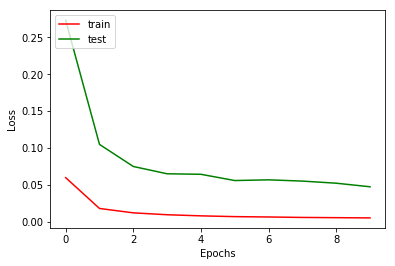

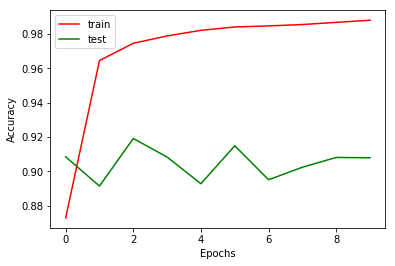

In [10]:
 # Plotting training loss vs Epochs
fig1 = plt.figure(1)        
plt.plot(range(iterations),trainLoss,'r-',label='train')  
plt.plot(range(iterations),testLoss,'g-',label='test') 

plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Loss')   

# Plotting testing accuracy vs Epochs
fig2 = plt.figure(2)        
plt.plot(range(iterations),trainAcc,'r-',label='train')    
plt.plot(range(iterations),testAcc,'g-',label='test')        

plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')  

In [11]:
import os

os.listdir(train_dir)

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'Basketball',
 'BasketballDunk',
 'BenchPress']

In [12]:
# Individual class performance
classes = os.listdir(train_dir)

class_correct = list(0. for i in range(10))   # Number of classes = 10
class_total = list(0. for i in range(10))

Batchsize = 10

with torch.no_grad():   # similar to net.train(False)
    for data in testLoader:
        images, labels = data
        images = Variable(images.cuda())
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu()
        c = (predicted == labels).squeeze()
        for i in range(Batchsize):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of ApplyEyeMakeup : 96 %
Accuracy of ApplyLipstick : 98 %
Accuracy of Archery : 84 %
Accuracy of BabyCrawling : 98 %
Accuracy of BalanceBeam : 77 %
Accuracy of BandMarching : 97 %
Accuracy of BaseballPitch : 99 %
Accuracy of Basketball : 93 %
Accuracy of BasketballDunk : 83 %
Accuracy of BenchPress : 77 %


<h2> Saving trained model </h2>

In [13]:
torch.save(net.state_dict(), 'resnetPre_fcOnly10class_ucf101_10adam_1e-4_b10.pt')